In [1]:
from yfinance import download
from numpy import where, nan
from pandas import isna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [24]:
def grafico_KDE(df_price, column, title, xlabel):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 3))
    # Plotando o histograma e a densidade (KDE)
    sns.histplot(df_price[column], kde=True, bins=30, color='darkblue', stat='density', linewidth=1.5)
    
    # Calculando estatísticas
    mean_return = np.mean(df_price[column])
    std_return = np.std(df_price[column])

    # Adicionando as estatísticas no gráfico
    plt.axvline(mean_return, color='darkred', linestyle='--', label=f'Média: {mean_return:.4f}')
    plt.axvline(mean_return + std_return, color='darkgreen', linestyle=':', label=f'1 Desvio Padrão: {mean_return + std_return:.4f}')
    plt.axvline(mean_return - std_return, color='darkgreen', linestyle=':')

    # Adicionando título e rótulos
    plt.title(title, fontsize=18, fontweight='bold', color='black')
    plt.xlabel(xlabel, fontsize=14, color='black')
    plt.ylabel('Densidade', fontsize=14, color='black')

    # Adicionando legenda com texto discreto
    plt.legend(facecolor='white', edgecolor='black', frameon=True)

    # Exibindo o gráfico
    plt.show()


In [31]:
def grafico_linha(df_price, column, title, xlabel='Date', ylabel='', label=''):
    df_price = df_price.reset_index()
    sns.set(style="whitegrid", palette="muted")
    plt.figure(figsize=(12, 3))

    # Plotando o gráfico de linha
    plt.plot(df_price['Date'], df_price[column], color='darkblue', label=label, linewidth=2)

    # Adicionando título e rótulos
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Adicionando legenda
    plt.legend()

    # Ajustando o layout do gráfico
    plt.xticks(rotation=45)  # Rotacionando os rótulos da data para facilitar a leitura
    plt.tight_layout()

    # Exibindo o gráfico
    plt.show()


# PREDIÇÃO DE DADOS BINÁRIOS

Predição da série dos retornos de ativos financeiros

In [3]:
ticker = 'GOAU4.SA'
start = '2012-05-12'
end = '2022-05-12'
column_variacao_percentual = 'Adj Close'
periodos_alvo = 1

In [4]:
df_price = download(ticker, start, end, progress=False)
df_price.tail(2)

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOAU4.SA,GOAU4.SA,GOAU4.SA,GOAU4.SA,GOAU4.SA,GOAU4.SA
Date,,,,,,
2022-05-10,8.179798,10.78,11.30,10.60,11.3,11194400
2022-05-11,8.498491,11.20,11.34,10.83,10.9,9818700


A ``variação percentual`` será utilizada para derivar variáveis de entrada que alimentam o modelo de aprendizado de máquina, auxiliando na identificação de padrões nos dados.

![alt text](Screenshot_1.png)

In [5]:
df_price['variacao_percentual'] = df_price[column_variacao_percentual].pct_change(periodos_alvo)
df_price.tail(2)

Price,Adj Close,Close,High,Low,Open,Volume,variacao_percentual
Ticker,GOAU4.SA,GOAU4.SA,GOAU4.SA,GOAU4.SA,GOAU4.SA,GOAU4.SA,
Date,,,,,,,
2022-05-10,8.179798,10.78,11.30,10.60,11.3,11194400,-0.054386
2022-05-11,8.498491,11.20,11.34,10.83,10.9,9818700,0.038961


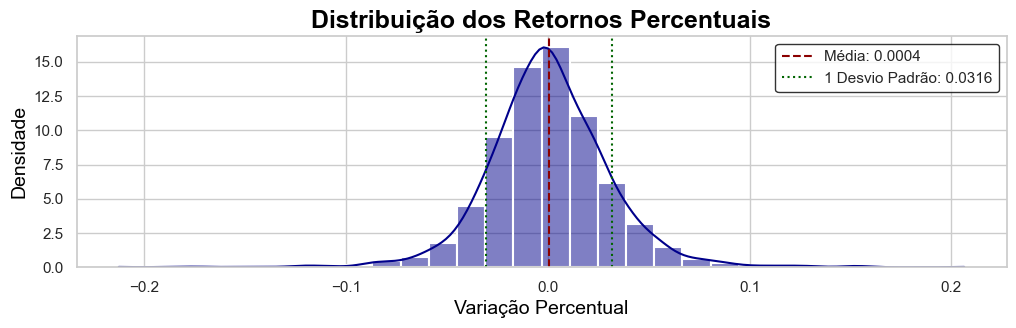

In [6]:
grafico_KDE(df_price, 'variacao_percentual', title='Distribuição dos Retornos Percentuais', xlabel='Variação Percentual')

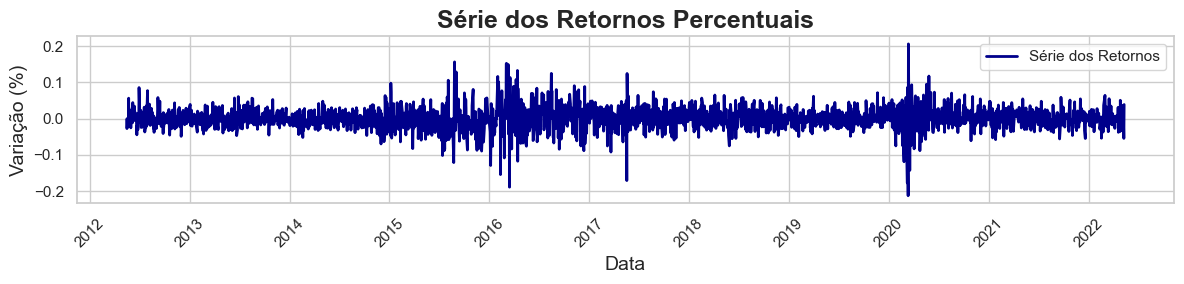

In [32]:
grafico_linha(df_price, 'variacao_percentual', 'Série dos Retornos Percentuais', 'Data', 'Variação (%)', label='Série dos Retornos')

Estou criando uma nova variável, `'alvo_numerico'`, que representa a diferença entre o preço de fechamento e o de abertura. Em seguida, desloca essa coluna para cima, preparando os dados para um modelo que utilizará a variação futura como "alvo" (o que o modelo tentará prever).

O último dado da coluna `'alvo_numerico'` é `NaN`, pois não existe um valor referente ao próximo dia para realizar o deslocamento.

In [7]:
df_price['alvo_numerico'] = df_price['Close'] - df_price['Open']
df_price['alvo_numerico'] = df_price['alvo_numerico'].shift(-periodos_alvo)
df_price.tail(3)

Price,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico
Ticker,GOAU4.SA,GOAU4.SA,GOAU4.SA,GOAU4.SA,GOAU4.SA,GOAU4.SA,,
Date,,,,,,,,
2022-05-09,8.650252,11.40,11.57,11.28,11.41,8711800,-0.020618,-0.52
2022-05-10,8.179798,10.78,11.30,10.60,11.30,11194400,-0.054386,0.30
2022-05-11,8.498491,11.20,11.34,10.83,10.90,9818700,0.038961,NaN


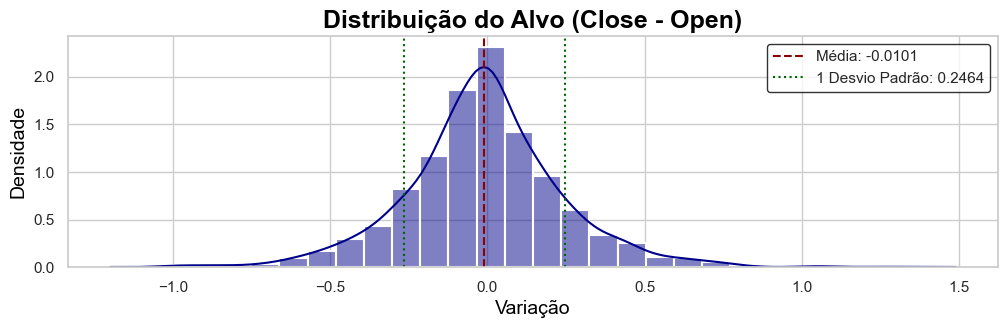

In [34]:
grafico_KDE(df_price, 'alvo_numerico', title='Distribuição do Alvo (Close - Open)', xlabel='Variação')

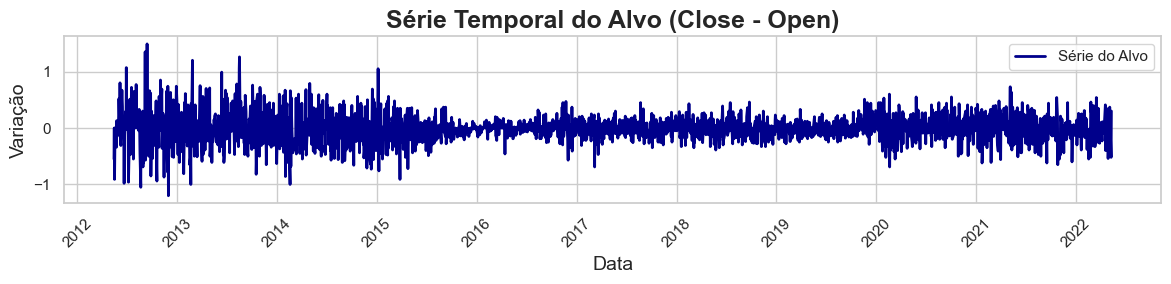

In [36]:
grafico_linha(df_price, 'alvo_numerico', title='Série Temporal do Alvo (Close - Open)', xlabel='Data', ylabel='Variação', label='Série do Alvo')

Ou seja, a previsão é realizada com base nos dados do dia anterior, e o alvo será o preço de fechamento do dia seguinte.



In [9]:
df_alvo_explicativo = df_price.copy()
df_alvo_explicativo = df_alvo_explicativo.reset_index()
df_alvo_explicativo['Date'] = df_alvo_explicativo['Date'].astype(str)
df_alvo_explicativo['variacao_numerica'] = df_alvo_explicativo['Close'] - df_alvo_explicativo['Open']
df_alvo_explicativo['alvo_numerico_e_data'] = (df_alvo_explicativo['variacao_numerica'].astype(str) + ' | ' + df_alvo_explicativo['Date'])
df_alvo_explicativo['alvo_numerico_e_data'] = df_alvo_explicativo['alvo_numerico_e_data'].shift(-periodos_alvo)
df_alvo_explicativo[['Date', 'Open', 'Close', 'variacao_percentual', 'alvo_numerico', 'alvo_numerico_e_data']].tail(3)


Price,Date,Open,Close,variacao_percentual,alvo_numerico,alvo_numerico_e_data
Ticker,,GOAU4.SA,GOAU4.SA,,,
2476,2022-05-09,11.41,11.40,-0.020618,-0.52,-0.5200004577636719 | 2022-05-10
2477,2022-05-10,11.30,10.78,-0.054386,0.30,0.3000001907348633 | 2022-05-11
2478,2022-05-11,10.90,11.20,0.038961,NaN,None


O cálculo do retorno real será feito com base na diferença entre o preço de abertura (Open) e o preço de fechamento (Close), em vez de utilizar a variação percentual.

Quando o valor de `alvo_numerico` para o próximo dia é `NaN` (por exemplo, quando não há dados disponíveis para o dia seguinte), eu considero que a previsão não é válida. Nesse caso, eu também defino o valor de `alvo_binario` como `NaN`, pois a previsão não pode ser feita adequadamente.

Se eu não fizer essa alteração, ao calcular o retorno real, o valor `NaN` no `np.where()` será considerado como `0`, o que pode gerar uma previsão errada ou inválida.

In [10]:
df_price['alvo_binario'] = where(df_price['alvo_numerico'] > 0, 1, 0)

if isna(df_price.iloc[-1, df_price.columns.get_loc('alvo_numerico')]).item():
    df_price.iloc[-1, df_price.columns.get_loc('alvo_numerico')] = nan
    df_price.iloc[-1, df_price.columns.get_loc('alvo_binario')] = nan

df_price.tail(3)

Price,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario
Ticker,GOAU4.SA,GOAU4.SA,GOAU4.SA,GOAU4.SA,GOAU4.SA,GOAU4.SA,,,
Date,,,,,,,,,
2022-05-09,8.650252,11.40,11.57,11.28,11.41,8711800,-0.020618,-0.52,0.0
2022-05-10,8.179798,10.78,11.30,10.60,11.30,11194400,-0.054386,0.30,1.0
2022-05-11,8.498491,11.20,11.34,10.83,10.90,9818700,0.038961,NaN,NaN


In [11]:
# Removendo o MultiIndex 
df_price.columns = df_price.columns.droplevel(1)
df_price.columns = list(df_price.columns)
df_price.tail(3)

,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario
Date,,,,,,,,,
2022-05-09,8.650252,11.40,11.57,11.28,11.41,8711800,-0.020618,-0.52,0.0
2022-05-10,8.179798,10.78,11.30,10.60,11.30,11194400,-0.054386,0.30,1.0
2022-05-11,8.498491,11.20,11.34,10.83,10.90,9818700,0.038961,NaN,NaN


Variáveis que serão utilizadas como entradas (inputs) para a predição no modelo de aprendizado de máquina.

O objetivo seria gerar um valor (representado por q) que possivelmente sirva como entrada para um modelo de previsão.

In [12]:
def __0__feature_exemplo_(df):
    Q = lambda x, t=5: x.rolling(t).mean()
    W = lambda x, t=5: x.rolling(t).sum()

    Z = 1 - df['Volume'] / df['Volume'].mean()
    Z = Z.diff() - Q(Z, 5).diff()

    X = W(df['variacao_percentual'], 10).diff() ** 2

    C = 1 / (1 - W(X.shift(1) - X.shift(5), 3) ** 2)

    q = (C + X) / (1 - Z)

    return q

df_price[0] = __0__feature_exemplo_(df_price)

df_price.tail(3)

,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario,0
Date,,,,,,,,,,
2022-05-09,8.650252,11.40,11.57,11.28,11.41,8711800,-0.020618,-0.52,0.0,2.225875
2022-05-10,8.179798,10.78,11.30,10.60,11.30,11194400,-0.054386,0.30,1.0,0.855191
2022-05-11,8.498491,11.20,11.34,10.83,10.90,9818700,0.038961,NaN,NaN,1.166287


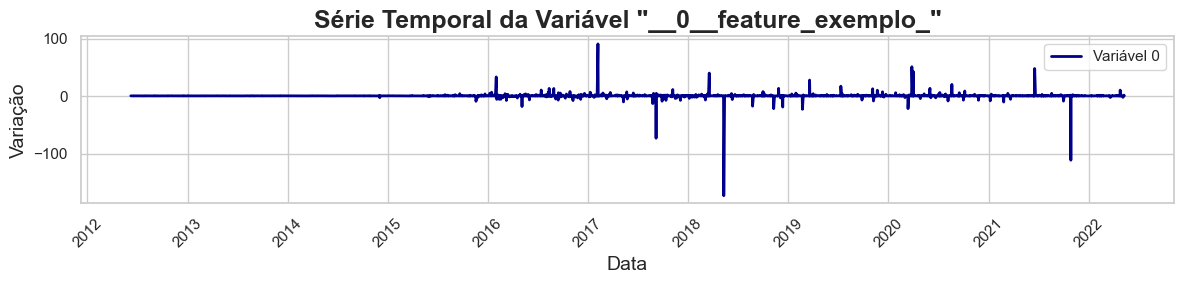

In [40]:
grafico_linha(df_price, 0, title='Série Temporal da Variável "__0__feature_exemplo_"', xlabel='Data', ylabel='Variação', label='Variável 0')

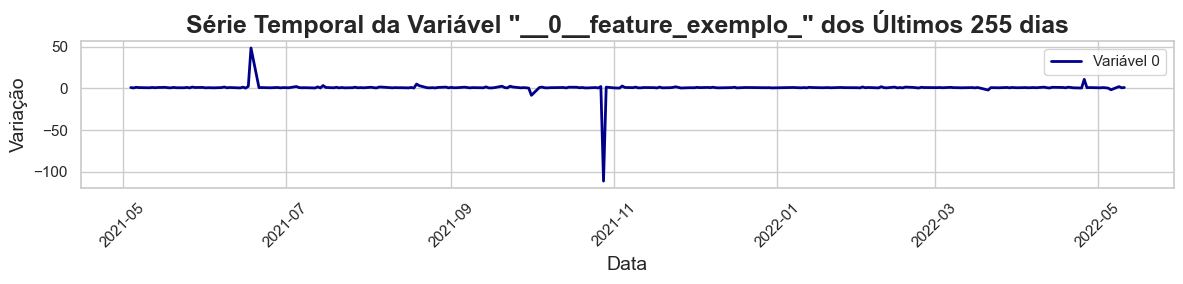

In [45]:
grafico_linha(df_price.tail(255), 0, title='Série Temporal da Variável "__0__feature_exemplo_" dos Últimos 255 dias', xlabel='Data', ylabel='Variação', label='Variável 0')

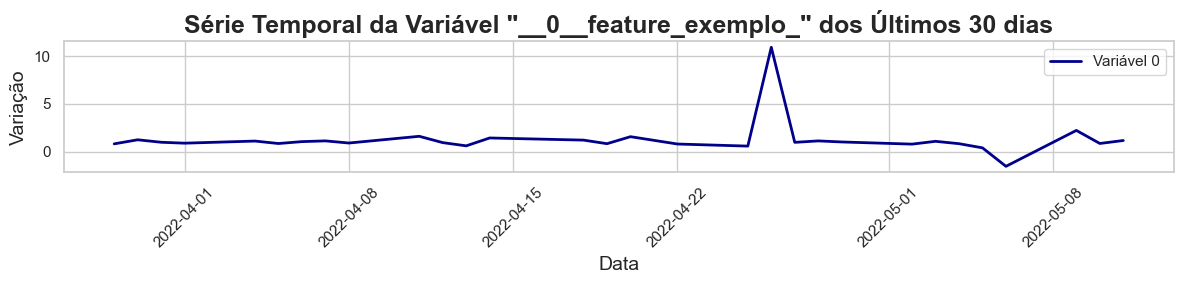

In [47]:
grafico_linha(df_price.tail(30), 0, title='Série Temporal da Variável "__0__feature_exemplo_" dos Últimos 30 dias', xlabel='Data', ylabel='Variação', label='Variável 0')

In [48]:
df_price[0].describe()

count    2461.000000
mean        1.002621
std         5.503117
min      -172.758824
25%         0.819066
50%         0.987739
75%         1.131124
max        91.370756
Name: 0, dtype: float64

In [50]:
print('Quantidade de Dados Perdidos da Variável 0: ', int(df_price[0].isnull().sum()))

Quantidade de Dados Perdidos da Variável 0:  18
